See original notebook : https://colab.research.google.com/drive/10CC4HaWagSZEMHLDYdK5LpL4O8YAdyVc

# Dimension Reduction with Random Projections 


Authors: R. M. Gower, Ange Valli

## Aim

The aim of this material is to
- to show that in practice dimension reduction can be used with no loss of accuracy on a classification problem
- code efficient sparse random projections
- apply sparse random projections together with knearest neighbors

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression    #Logistic Regression
from sklearn.neighbors import KNeighborsClassifier 

def get_data(dataname):
    data = load_svmlight_file(dataname)
    return data[0], data[1]

## Part 1 : LogisticRegression and random sparse projections: 

Use LogisticRegression classifier of Scikit-learn to experimentally confirm the corollary of Range Space Preserving Theorem and test random sparse projections

### Corollary of Range Space Preserving Theorem  

Let 
$$ X = [x_1, \ldots, x_n] \in \mathbb{R}^{n\times d},$$
be our data matrix and let
$$  X^\top X  = [\hat{x}_1, \ldots, \hat{x}_n]^\top \in \mathbb{R}^{n\times n}. $$
We can find a solution to the following training problem
$$ w^* \in \min_{w \in \mathbb{R}^d}  F(w) :=\frac{1}{n}\sum_{i=1}^n \ell_i(\langle x_i,w \rangle) \hspace{3cm} (I)$$
by instead solving 
$$ \hat{w}^* \in \min_{w \in \mathbb{R}^n} F_X(w) := \frac{1}{n}\sum_{i=1}^n \ell_i(\langle \hat{x}_i,w \rangle) \hspace{3cm} (II)$$
and  $ X \hat{w}^*$ is a solution to $(I)$

### End Corollary

In [ ]:
dataname = 'colon-cancer.bz2'

In [ ]:
# download the colon-cancer data set from 
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/colon-cancer.bz2
# Unpack and place in the same folder as this python notebook
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/colon-cancer.bz2
!bunzip2 colon-cancer.bz2
XT, y = get_data(dataname)
XT_train, XT_test, y_train, y_test = train_test_split(XT, y, test_size=0.33, random_state=42)
n, d = XT_train.shape
print('{n} data points and {d} features'.format(n = n,d =d))

--2021-11-17 08:45:09--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/colon-cancer.bz2
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609480 (595K) [application/x-bzip2]
Saving to: ‘colon-cancer.bz2’

colon-cancer.bz2    100%[===================>] 595.20K   739KB/s    in 0.8s    

2021-11-17 08:45:11 (739 KB/s) - ‘colon-cancer.bz2’ saved [609480/609480]

bunzip2: Output file colon-cancer already exists.
41 data points and 2000 features


In [ ]:
C0 = 1.0000e+09# almost no regularization inverse of the regularization parameter, i.e, C = 1/lambda
log_reg = LogisticRegression(C = C0) # , multi_class = "multinomial"
log_reg.fit(XT_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(XT_train,y_train)))
print('Accuracy on the test set: {:.3f}'.format(log_reg.score(XT_test,y_test)))

Accuracy on the training set: 1.000
Accuracy on the test set: 0.619


In [ ]:
# Using XtX instead
# define a new dataset
XTX_train, XTX_test, y_hat_train, y_hat_test = train_test_split(np.dot(XT,np.transpose(XT)), y, test_size=0.33, random_state=42)
n_hat, d_hat = XTX_train.shape
print('{n} data points and {d} features'.format(n = n_hat,d =d_hat))

log_reg2 = LogisticRegression(C = C0) # , multi_class = "multinomial"
log_reg2.fit(XTX_train, y_hat_train)
print('Accuracy on the training set fot Xt: {:.3f}'.format(log_reg2.score(XTX_train, y_hat_train)))
print('Accuracy on the test set: {:.3f}'.format(log_reg2.score(XTX_test, y_hat_test)))

41 data points and 62 features
Accuracy on the training set fot Xt: 1.000
Accuracy on the test set: 0.571


By setting the regularization parameter close to zero ($C = 10^9$) in LogisticRegression, the score obtained by training using $X$ and $X^\top X$ is the same. We find $1.0$ accuracy in both cases. 

We compute a solution $w^*_1$  by directly solving $(I)$

In [ ]:
w_star = log_reg.coef_
print("Solution obtained for (I) :{}".format(w_star))

# Compare this $w^*_1$ to the recovered solution $X^\top \hat{w}^*$.
Xw_hat = np.dot(log_reg2.coef_,  XT.todense())
print("X.w_hat* : {}".format(Xw_hat))

# Are they the same? Justify based on Corollary.
print("Are they the same ? {}".format(np.mean(w_star - Xw_hat)==0))
#############

Solution obtained for (I) :[[ 0.05698562 -0.00462794 -0.02875027 ... -0.08827836  0.03863623
  -0.01783449]]
X.w_hat* : [[ 0.1216772   0.02080941 -0.03861272 ... -0.17135291  0.17468736
   0.03159193]]
Are they the same ? False


We compare this $w^*_1$ to the recovered solution $X^\top \hat{w}^*$. We show $w^*_1$ and $X^\top \hat{w}^*$ are different vectors.

In fact, they are two vectors which are two different minimizers of the min problems. This is coherent with the fact that the representation changed between the two problems.


Now, we use a random generated gaussian matrix $W \in\mathbb{R}^{d\times r}$  and project the data matrix $X \rightarrow W^\top X$. We test for different values of $r$ and
apply logistic regression to the resulting projected matrix.

project dimension    1 gives: (train, test) =  (0.7317, 0.5714)
project dimension  201 gives: (train, test) =  (1.0000, 0.5714)
project dimension  401 gives: (train, test) =  (1.0000, 0.7619)
project dimension  601 gives: (train, test) =  (1.0000, 0.6667)
project dimension  801 gives: (train, test) =  (1.0000, 0.6667)
project dimension 1001 gives: (train, test) =  (1.0000, 0.6190)
project dimension 1201 gives: (train, test) =  (1.0000, 0.5714)
project dimension 1401 gives: (train, test) =  (1.0000, 0.6667)
project dimension 1601 gives: (train, test) =  (1.0000, 0.6190)
project dimension 1801 gives: (train, test) =  (1.0000, 0.6190)
Best score was for r =  401 with: (train, test) =  (1.0000, 0.7619)


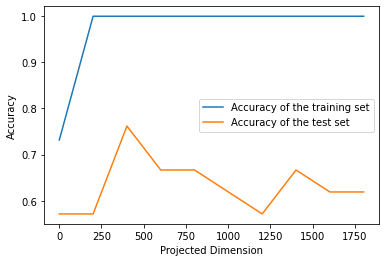

In [ ]:
from sklearn.random_projection import GaussianRandomProjection
## Choose a range of different projected dimensions to test
## Suggested range of projected dimensions:
upperbnd = d
project_dimensions = range(1,upperbnd,int((upperbnd )/10))
#############
test_accuracy = []
training_accuracy = []

for r in project_dimensions: 
    #    project the data matrix $X \rightarrow XW$ using Gaussian and fit, 
    #    transform and score using Logstic Regression

    transformer = GaussianRandomProjection(r)
    X_new = transformer.fit_transform(XT)

    XT_train, XT_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    log_reg = LogisticRegression(C = C0) 
    log_reg.fit(XT_train, y_train)

    # trainscore
    trainscore = log_reg.score(XT_train, y_train)
    training_accuracy.append(trainscore)

    # testscore 
    testscore= log_reg.score(XT_test, y_test)
    test_accuracy.append(testscore)
    #############
    print ("project dimension %4d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))
#    coef_recover= log_regt.coef_.dot(X_train.transpose())

plt.plot(project_dimensions,training_accuracy, label='Accuracy of the training set')
plt.plot(project_dimensions,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (project_dimensions[index_max], training_accuracy[index_max],test_accuracy[index_max]))

For the training set, a projected dimension $r \geqslant 250$ is needed to get the same accuracy (1.0) as before. 
Regarding the test set, we have in general the same accuracies (around $0.6$), sometimes better for some values of $r$. 

We can also notice that $r$ increasing does not always means a better testing accuracy.

## Part 2:

Instead of using $X \rightarrow W^\top X$, we use $X^\top \rightarrow X^\top W$



Now we will train a model using a large text based data set. We need to code the following random transform $W \in \mathbb{R}^{d \times r}$ that takes a sparsity parameter $s$ as an input and outputs a matrix

$$ 
W_{ij}  = \sqrt{\frac{s}{r}}
\begin{cases}
1 \quad & \mbox{with probability }\frac{1}{2s} \\
0 \quad & \mbox{with probability }1-\frac{1}{s} \\
-1 \quad & \mbox{with probability }\frac{1}{2s} 
\end{cases}
$$

We will test if random projections are able to preserve pairwise distances by applying K-Neighrest Neighbors to projected data. 


In [ ]:
import scipy
from sklearn.utils.extmath import safe_sparse_dot   ## <-- I recommend using this function
from sklearn.utils.random import sample_without_replacement  ## <-- I recommend using this function
import random

The following function Generate_Sparse_Transform$(s,r,d)$ takes at inputs the sparsity parameter  $s$, the input dimension $d \in \mathbb{N}$ and the lower dimensional projected dimension $r \in \mathbb{N}$. It gives as outputs the matrix $W$ stored in an efficient sparse format, the CSC format (scipy.sparse.csc_matrix)

In [ ]:
def GenerateSparseTransform(s,r,d):
    """ returns W : sparse matrix """

    # ##### SUBOPTIMAL BUT WORKS FOR 1st DATA #######
    # W = np.zeros((d,r))
    # for j in range(r):
    #   for i in range(d):
    #     proba = random.random()
    #     if proba <= 1/(2*s):
    #       W[i][j]= np.sqrt(s/r)
    #     elif proba >= 1- 1/(2*s):
    #       W[i][j]= -np.sqrt(s/r)
    #     # else stays at zero

    # # sample without replacement 1/(2s)*d*r indices to change
    # i_indices = sample_without_replacement(d, int(d/s)) # get row indices to put non null coeffs
    # j_indices = sample_without_replacement(r, int(r/s) )

    # We used random randint instead to make sure the array of indices is of data shape
    data = np.sqrt(s/r)* np.array([1,-1]*int(d*r/(2*s)))
    np.random.shuffle(data)
    i_indices = np.random.randint(d,size=data.shape) # get where to fullfill W
    j_indices = np.random.randint(r,size=data.shape)

    return scipy.sparse.csc_matrix((data,(i_indices,j_indices)),(d,r))
    #return scipy.sparse.csc_matrix(W)

The function Apply_Sparse_Transform$(R,X)$ takes as inputs the random transform $W$ as generated by  Generate\_sparse\_transform$(s,r,d)$, a given data matrix $X^\top \in \mathbb{R}^{n\times d}$. The output is $X^\top W$. An efficient implementation using sparse matrix properties is necessary to prevent running out of memory.

In [ ]:
def ApplySparseTransform(W,X_):
#     W   : Sparse randomly generated matrix of size d by r
#     X_  : Data matrix to be compressed, of size n by d
#    NOTE: The dimensions of W and X_ are such that the product X_*W is defined (which is different that what we used in class)
    Xtransformed = safe_sparse_dot(X_, W, True) # return a dense matrix 
    return Xtransformed

## Load and test dataset *anthracyclineTaxaneChemotherapy*

We load the dataset $X^\top$ on anthracyclineTaxaneChemotherapy.

In [ ]:
import pandas as pd

In [ ]:
# Use fetch_openml
from sklearn.datasets import fetch_openml
chemo = fetch_openml(name='anthracyclineTaxaneChemotherapy')

In [ ]:
# In case of failure in fetch_openml, we download the dataset in arff format and load it using the following code
from scipy.io import arff
!wget https://www.openml.org/data/download/1390177/phpCLGrjq
dataset = arff.loadarff('phpCLGrjq.arff')
Xdf = pd.DataFrame(dataset[0])
Xy = Xdf.to_numpy()
n_rows, n_cols = Xy.shape
XT = Xy[:,:-1]
XT = np.float_(XT)
y = Xy[:,-1]
y = (np.int_(y))*2-3

In [ ]:
# Split test and training. Only use 20% of data for testing because data set is small. 
XT_train, XT_test, y_train, y_test = train_test_split(XT, y, test_size=0.20, random_state=42) 
n, d = XT_train.shape
print('{n} training data points and {d} features'.format(n = n,d =d))

Fit, transform and score sklearn's KNeighborsClassifier on this data

In [ ]:
n_neighbors = 2
 
# Fit knn Classifier KNeighborsClassifier on the training data. Print the training and test error
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(XT_train, y_train)
training_score = neigh.score(XT_train, y_train)
# test score
test_score = neigh.score(XT_test, y_test)

print("Training score : {}".format(training_score))
print("Test score : {}".format(test_score))
#############

Training score : 0.84251968503937
Test score : 0.5625


Now, we first randomly project that data using $X^\top$ -> $X^\top W$ before the steps of fit, transform and score. We can use different values of the sparsity parameter $s$ and projected dimension parameter $r$. Values for s such as $s = \sqrt{r}$, $s= \log(r)$ or simply $s=20$ often works well.

project dim    30 gives: (train, test) =  (0.8110, 0.5625)
project dim   154 gives: (train, test) =  (0.7953, 0.5938)
project dim   278 gives: (train, test) =  (0.8740, 0.5625)
project dim   402 gives: (train, test) =  (0.8110, 0.5625)
project dim   526 gives: (train, test) =  (0.8976, 0.5312)
project dim   650 gives: (train, test) =  (0.8425, 0.5938)
project dim   774 gives: (train, test) =  (0.8268, 0.5938)
project dim   898 gives: (train, test) =  (0.8504, 0.5625)
project dim  1022 gives: (train, test) =  (0.8189, 0.6250)
project dim  1146 gives: (train, test) =  (0.8346, 0.7188)
Best score was for r = 1146 with: (train, test) =  (0.8346, 0.7188)


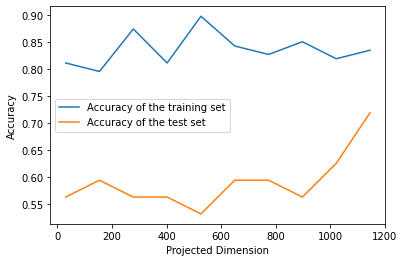

In [ ]:
test_accuracy = []
training_accuracy = []
n_neighbors = 2

upperbnd = int(min(10*n,d/2))
minbnd = int(max(n/20,d/2000))
project_dimensions = range(minbnd,upperbnd,int((upperbnd -minbnd)/10))

 for r in project_dimensions:    
    s = np.sqrt(r)

    ## Project after splitting
    W = GenerateSparseTransform(s,r,d)
    X_proj_train = ApplySparseTransform(W,XT_train)
    X_proj_test = ApplySparseTransform(W,XT_test)

    neigh = KNeighborsClassifier(n_neighbors)

    neigh.fit(X_proj_train, y_train)
    trainscore = neigh.score(X_proj_train, y_train)
    training_accuracy.append(trainscore)

    testscore = neigh.score(X_proj_test, y_test)
    test_accuracy.append(testscore)

    print ("project dim %5d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))

list_proj_dims = list(project_dimensions)
plt.plot(list_proj_dims,training_accuracy, label='Accuracy of the training set')
plt.plot(list_proj_dims,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (list_proj_dims[index_max], training_accuracy[index_max],test_accuracy[index_max]))

## Load and test dataset *sector.scale*

Now, we load the dataset $X^\top$ on *sector.scale* which is larger than the previous dataset, and we repeat the same steps.

In [ ]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/sector/sector.scale.bz2
dataname = "sector.scale.bz2"  
X, y = get_data(dataname)
n, d = X.shape
print('{n} data points and {d} features'.format(n = n,d =d))

6412 data points and 55197 features


In [ ]:
# split test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
n, d = X_train.shape
print('{n} trainig data points and {d} features'.format(n = n,d =d))

In [ ]:
# fit for harder dataset
n_neighbors =1

neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(X_train, y_train)
training_score = neigh.score(X_train, y_train)
# test score
test_score = neigh.score(X_test, y_test)

print("Training score : {}".format(training_score))
print("Test score : {}".format(test_score))
#############

Training score : 1.0
Test score : 0.8827977315689981


Because of volume issues, we only test project dimensions $r \leqslant \lfloor(min(2*n,\frac{d}{2}) \rfloor$

project dim   214 gives: (train, test) =  (1.0000, 0.7684)
project dim  1051 gives: (train, test) =  (1.0000, 0.8634)
project dim  1888 gives: (train, test) =  (1.0000, 0.8748)
project dim  2725 gives: (train, test) =  (1.0000, 0.8767)
project dim  3562 gives: (train, test) =  (1.0000, 0.8785)
project dim  4399 gives: (train, test) =  (1.0000, 0.8781)
project dim  5236 gives: (train, test) =  (1.0000, 0.8790)
project dim  6073 gives: (train, test) =  (1.0000, 0.8776)
project dim  6910 gives: (train, test) =  (1.0000, 0.8762)
project dim  7747 gives: (train, test) =  (1.0000, 0.8804)
project dim  8584 gives: (train, test) =  (1.0000, 0.8809)
Best score was for r = 8584 with: (train, test) =  (1.0000, 0.8809)


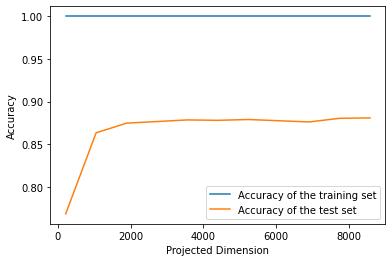

In [ ]:
test_accuracy = []
training_accuracy = []
n_neighbors = 1   ## <-- I recommend using this
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

upperbnd = int(min(2*n,d/2)) # Only test project dimensions r <= int(min(2*n,d/2))
minbnd = int(max(n/20,d/2000))
project_dimensions = range(minbnd,upperbnd,int((upperbnd -minbnd)/10))

for r in project_dimensions:  

    s = np.sqrt(r)
    W = GenerateSparseTransform(s,r,d)

    Xt_train = ApplySparseTransform(W,X_train)
    Xt_test =  ApplySparseTransform(W,X_test)


    knn.fit(Xt_train, y_train)
    trainscore = knn.score(Xt_train, y_train)
    training_accuracy.append(trainscore)

    testscore = knn.score(Xt_test, y_test)
    test_accuracy.append(testscore)

    #############
    print ("project dim %5d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))

list_proj_dims = list(project_dimensions)
plt.plot(list_proj_dims,training_accuracy, label='Accuracy of the training set')
plt.plot(list_proj_dims,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (list_proj_dims[index_max], training_accuracy[index_max],test_accuracy[index_max]))

By writing $W$ matrix randomly, we were able to apply a transform on large datasets.
Also, we saw that random projections are able to preserve pairwise distances by applying K-Neighrest Neighbors after projecting the training and testing data, obtaining similar testing score as without the projection.


## Part 3 : the Johnson-Lindenstrauss Lemma

Using the Jonhson-Lindenstrauss Lemma, we can have an estimate for the projected dimension using

$$r = \frac{1}{\epsilon^2}\log(\frac{n}{\delta}) $$

We test for each of the above datasets with $\epsilon = 0.05 = \delta$ and compare to the previous results. 

In [ ]:
def r(epsilon, n, delta):
  return 1/ epsilon**2 * np.log(n/delta)

In [ ]:
# first dataset :
dataset = arff.loadarff('phpCLGrjq.arff')
Xdf = pd.DataFrame(dataset[0])
Xy = Xdf.to_numpy()
n_rows, n_cols = Xy.shape
XT = Xy[:,:-1]
X_chemo = np.float_(XT)
y = Xy[:,-1]
y_chemo = (np.int_(y))*2-3

X_chemo_train, X_chemo_test, y_chemo_train, y_chemo_test = train_test_split(X_chemo, y_chemo, test_size=0.33, random_state=42)
n_chemo, d_chemo = X_chemo_train.shape

# second dataset
dataname = "sector.scale.bz2"  
X_sector, y_sector = get_data(dataname)
X_sec_train, X_sec_test, y_sec_train, y_sec_test = train_test_split(X_sector, y_sector, test_size=0.33, random_state=42)
n_sector, d_sector = X_sec_train.shape

In [ ]:
print("Estimated projected value for first dataset (chemo)", r(0.05, n_chemo, 0.05))
print("Estimated projected value for second dataset (sector scale)", r(0.05, n_sector, 0.05))

Estimated projected value for first dataset (chemo) 3063.668547066423
Estimated projected value for second dataset (sector scale) 4544.468763897076


In [ ]:
# Test for first dataset 
r_chemo = r(0.05, n_chemo, 0.05)
s_chemo = np.sqrt(r_chemo)

W_che = GenerateSparseTransform(s_chemo,int(r_chemo),d_chemo)

Xt_train = ApplySparseTransform(W_che,X_chemo_train)
Xt_test =  ApplySparseTransform(W_che,X_chemo_test)

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(Xt_train, y_chemo_train)
trainscore = knn.score(Xt_train, y_chemo_train)
training_accuracy.append(trainscore)
print("Training", trainscore)

testscore = knn.score(Xt_test, y_chemo_test)
test_accuracy.append(testscore)
print("Testing", testscore)

Training 0.8113207547169812
Testing 0.6037735849056604


In [ ]:
# Test for second dataset 
r_sector = r(0.05, n_sector, 0.05)
s_sector = np.sqrt(r_sector)

W_sec = GenerateSparseTransform(s_sector,int(r_sector),d_sector)

Xt_train = ApplySparseTransform(W_sec,X_sec_train)
Xt_test =  ApplySparseTransform(W_sec,X_sec_test)

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(Xt_train, y_sec_train)
trainscore = knn.score(Xt_train, y_sec_train)
training_accuracy.append(trainscore)
print("Training", trainscore)
testscore = knn.score(Xt_test, y_sec_test)
test_accuracy.append(testscore)
print("Testing", testscore)

Training 0.9350558659217877
Testing 0.8482986767485823


Thanks to this method, we find in general a better testing accuracy with this value of $r$ than the maximum of the bounds we obtain in Part 2. 
